In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

Para el trabajo se eligió un dataset con datos de dos años del consumo eléctrico por hora de un departamento en San Jose, California. Como el dataset tenía tantas entradas se decidió tomar el valor de consumo máximo diario. Esto redujo el dataset de 70.000 entradas a 733 entradas.

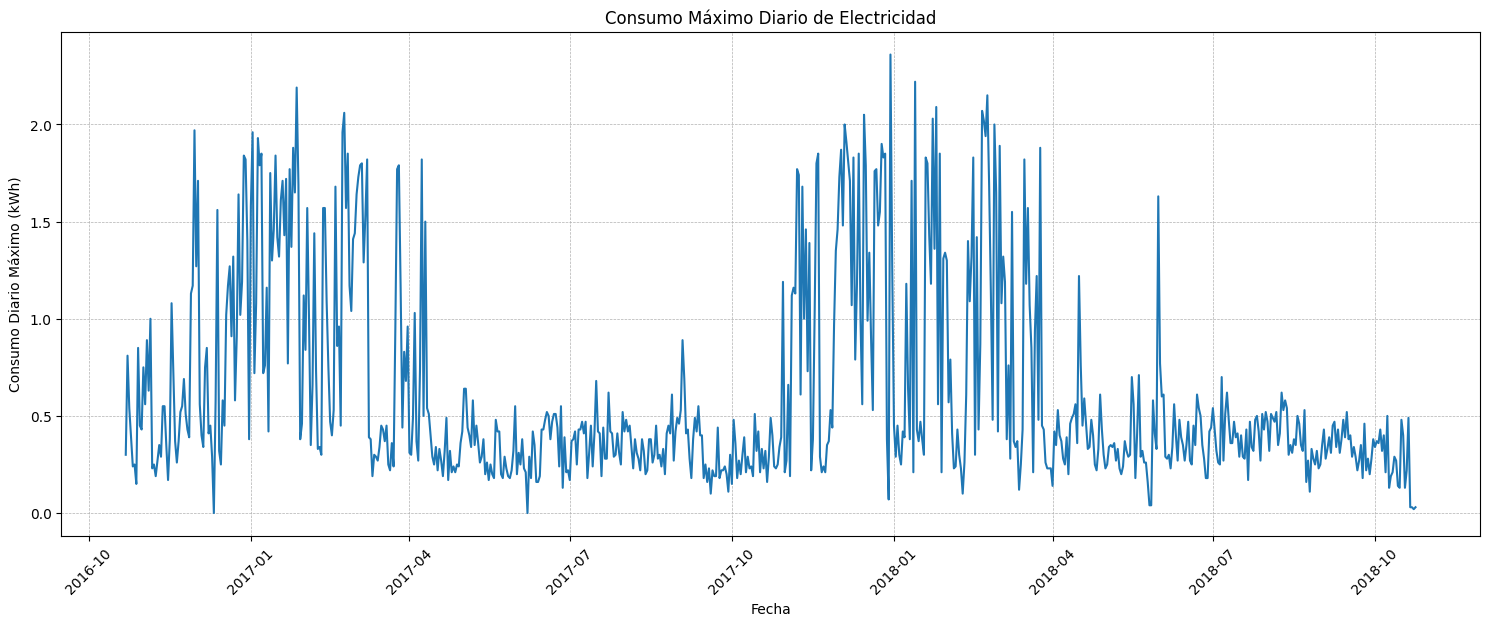

In [3]:
df = pd.read_csv("Datasets/tp_final/df_max_usage.csv")
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index(df["DATE"])

df.replace(0, 1e-100, inplace=True)

plt.figure(figsize=(15, 6))
plt.plot(df['DATE'], df['MAX_USAGE'])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('Fecha')
plt.ylabel('Consumo Diario Máximo (kWh)')
plt.title('Consumo Máximo Diario de Electricidad')
plt.tight_layout()

if len(df) > 50:
    plt.xticks(rotation=45)

plt.show()

Como se puede observar, es una serie discreta y univariada. Claramente presenta estacionalidad: en los meses más fríos en California, de octubre a abril, el consumo de electricidad aumenta considerablemente. De la misma manera, en los meses más cálidos disminuye considerablemente. En primer lugar no pareciera ser estacionaria, porque, a simple vista, la media y la varianza de los valores cambia a lo largo del tiempo.
La serie se descompone utilizando el **modelo multiplicativo**, utilizando un **período de 365 días** (o entradas). Este período ha sido seleccionado para capturar la ventana de tiempo en la cual se observa la estacionalidad.


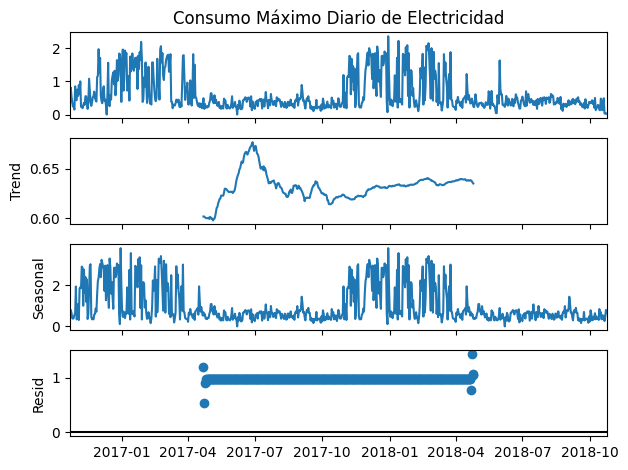

In [4]:
series = pd.Series(
    df['MAX_USAGE'].values, index=df['DATE'], name="Consumo Máximo Diario de Electricidad"
)

period = 365
decomposition = seasonal_decompose(series, model='multiplicative', period=period)
decomposition.plot()
plt.show()

Como se puede observar este modelo no parece ser efectivo para el estudio de la serie: la componente estacional termina sirviendo para represnetar casi toda la serie original. La tendencia y los residuos son marginales. Este mismo problema sucede si se usa un modelo aditivo.

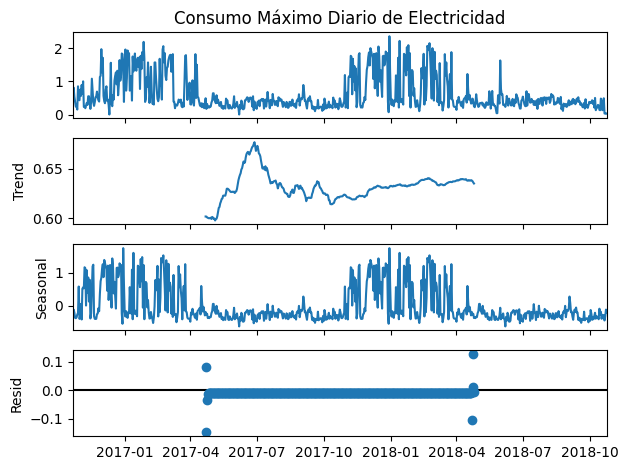

In [5]:
period = 365
decomposition = seasonal_decompose(series, model='additive', period=period)
decomposition.plot()
plt.show()

Se decide entonces estimar una tendencia de forma manual, para despues restarle los efectos de esta tendencia a la serie original.
Como se puede estimar a simple vista el periodo es de 360 dias.

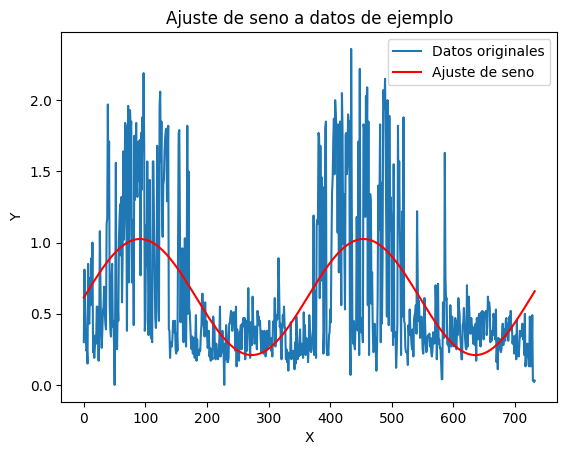

Parámetros ajustados:
Amplitud (A): -0.8151705077182209
Frecuencia (omega): 0.008658038926308103
Fase (phi): 2.3519707148840947
Desplazamiento (offset): 1.0248747731056256


In [6]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

x_list = np.array(list(range(len(series.index))))
y_list = series.values

def sine_func(x, A, omega, phi, offset):
    return A * np.sin(omega * x + phi) ** 2 + offset

A_guess = 2
omega_guess = 1/365
phi_guess = 0
offset_guess = 0

params, covariance = curve_fit(sine_func, x_list, y_list, p0=[A_guess, omega_guess, phi_guess, offset_guess], maxfev=10*5000)

A_fit, omega_fit, phi_fit, offset_fit = params

y_fit = sine_func(x_list, A_fit, omega_fit, phi_fit, offset_fit)


plt.plot(x_list, y_list, label='Datos originales')
plt.plot(x_list, y_fit, color='red', label='Ajuste de seno')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Ajuste de seno a datos de ejemplo')
plt.show()

print('Parámetros ajustados:')
print('Amplitud (A):', A_fit)
print('Frecuencia (omega):', omega_fit)
print('Fase (phi):', phi_fit)
print('Desplazamiento (offset):', offset_fit)


Ahora se divide la serie original por el estimado, de forma de remover esta tendencia estimada de la serie.


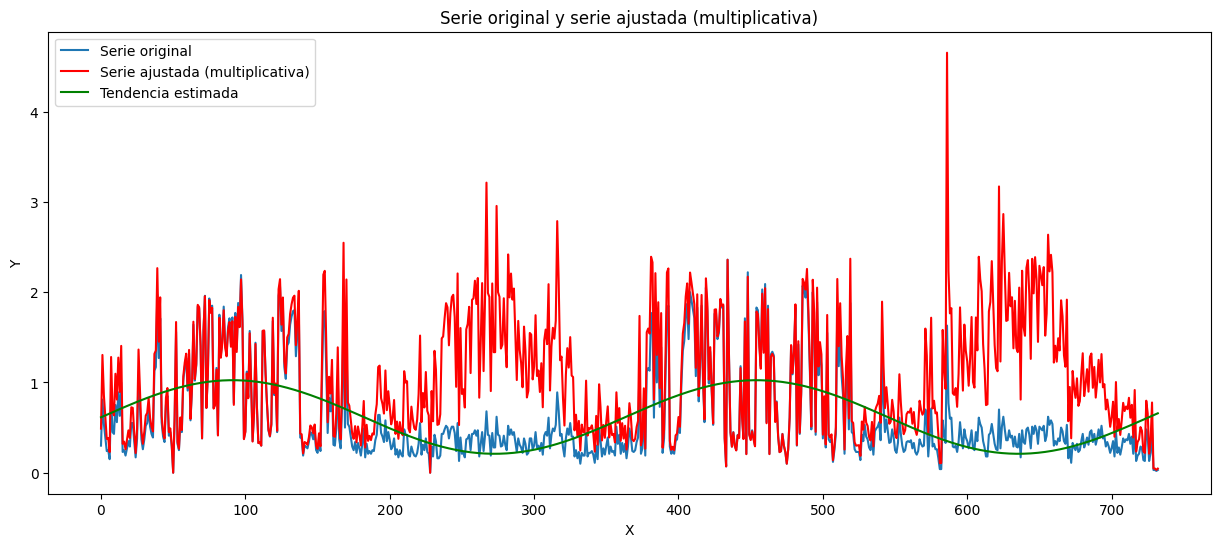

In [7]:
serie_ajustada_multiplicativa = y_list / y_fit

plt.figure(figsize=(15, 6))
plt.plot(x_list, y_list, label='Serie original')
plt.plot(x_list, serie_ajustada_multiplicativa, color='red', label='Serie ajustada (multiplicativa)')
plt.plot(x_list, y_fit, color='green', label='Tendencia estimada')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Serie original y serie ajustada (multiplicativa)')
plt.show()

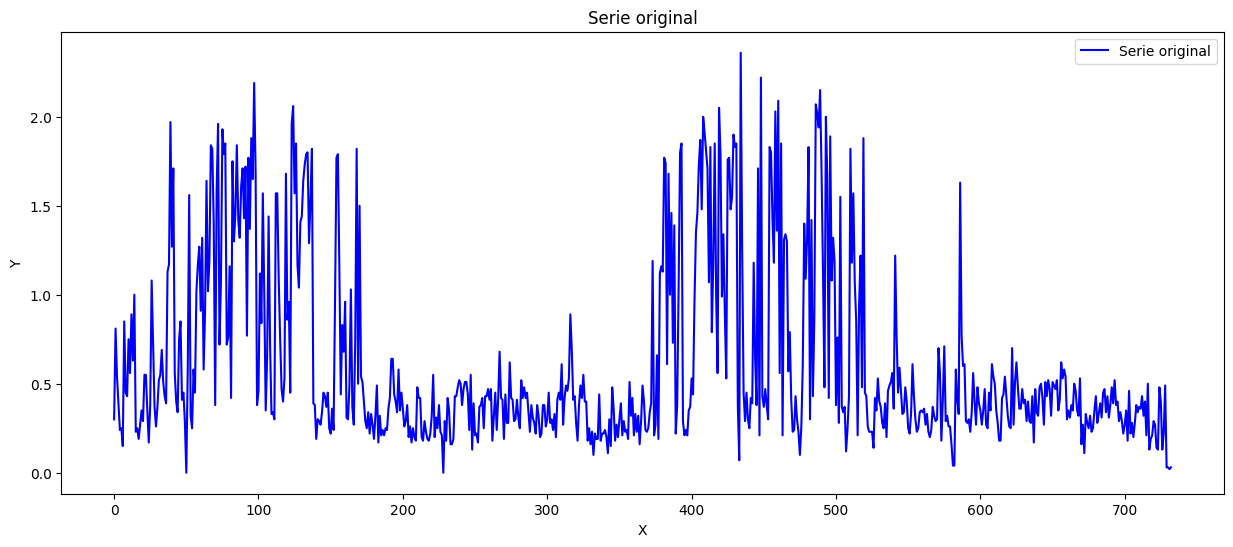

In [8]:
plt.figure(figsize=(15, 6))
plt.plot(x_list, y_list, color='blue', label='Serie original')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Serie original')
plt.show()

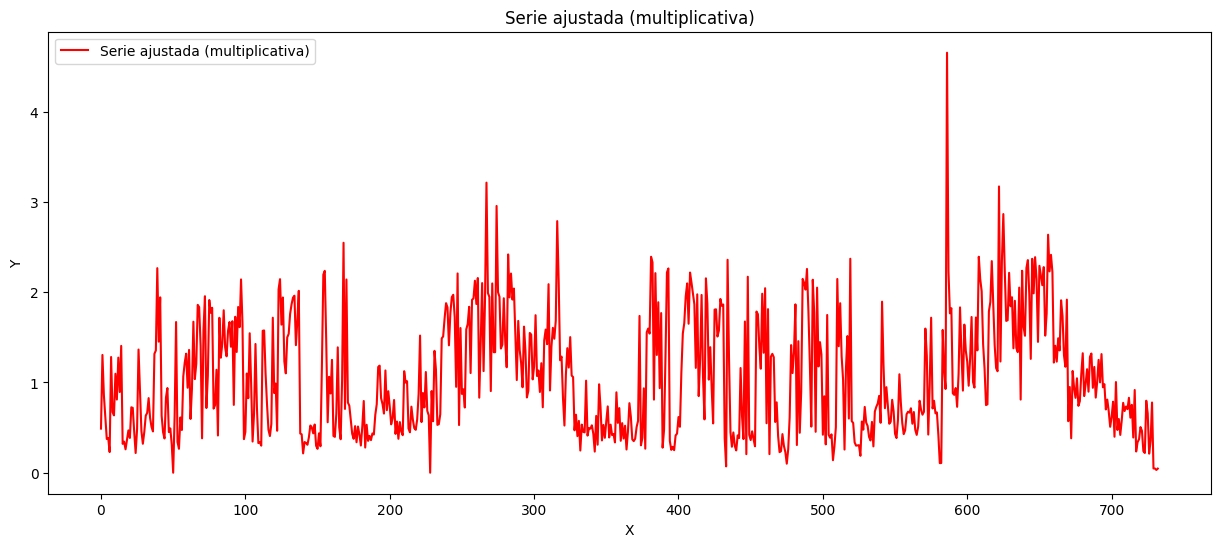

In [9]:
plt.figure(figsize=(15, 6))
plt.plot(x_list, serie_ajustada_multiplicativa, color='red', label='Serie ajustada (multiplicativa)')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Serie ajustada (multiplicativa)')
plt.show()

Para los siguientes ajustes se buscar transformar los modelos de forma de encontrar una serie estacionaria con la menor cantidad de transformaciones posibles. Se testeara estacionareidad usando ADF y KPSS, con un nivel de significancia de 5%.

Se resumen rapidamente ADF y KPSS, como referencia

**ADF**

Hipótesis Nula (H0): La hipótesis nula en la Prueba de Dickey-Fuller es que la serie temporal tiene una raíz unitaria, lo que implica que no es estacionaria.

Hipótesis Alternativa (H1): La hipótesis alternativa es que la serie temporal no tiene una raíz unitaria, lo que implica que es estacionaria.

Test Statistic:
    Si es más negativo que los valores críticos, hay suficiente evidencia para rechazar la hipótesis nula de no estacionariedad. Un valor más negativo indica una mayor probabilidad de estacionariedad.
    Si es menos negativo que los valores críticos, no hay suficiente evidencia para rechazar la hipótesis nula.

p-value:
    Un valor p pequeño (generalmente < 0.05) sugiere que hay suficiente evidencia para rechazar la hipótesis nula de no estacionariedad y que la serie temporal es estacionaria.
    Un valor p grande (generalmente > 0.05) indica que no hay suficiente evidencia para rechazar la hipótesis nula.

**KPSS**

Hipótesis Nula (H0): La hipótesis nula en la Prueba de KPSS es que la serie temporal es estacionaria en torno a una tendencia determinista.

Hipótesis Alternativa (H1): La hipótesis alternativa es que la serie temporal es no estacionaria, lo que implica que tiene una tendencia estocástica o una raíz unitaria.

Test Statistic (Estadístico de Prueba):
    Si es mayor que los valores críticos, hay suficiente evidencia para rechazar la hipótesis nula.
    Si es menor que los valores críticos, no hay suficiente evidencia para rechazar la hipótesis nula.

p-value (Valor p):
    Un valor p pequeño (generalmente < 0.05) sugiere que hay suficiente evidencia para rechazar la hipótesis nula y que la serie temporal es no estacionaria.
    Un valor p grande (generalmente > 0.05) indica que no hay suficiente evidencia para rechazar la hipótesis nula.

Critical Values (Valores Críticos):
    Compara el estadístico de prueba con estos valores para determinar su significancia.
    Si el estadístico de prueba es mayor que los valores críticos, hay suficiente evidencia para rechazar la hipótesis nula.


In [12]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss

# Supongamos que tienes tu serie temporal en un DataFrame de pandas
# Por ejemplo, si tus datos están en un archivo CSV llamado 'datos.csv':
# df = pd.read_csv('datos.csv')

# Aquí supongo que tienes tus datos ya cargados en un DataFrame llamado 'serie_temporal'
# Asegúrate de que tu serie temporal esté en una sola columna con fechas en el índice

# Primero, definimos una función para realizar las pruebas
def test_stationarity(timeseries):
    timeseries = timeseries.dropna()
    # Reemplazar infinitos con NaN y luego eliminar filas con valores faltantes
    timeseries = timeseries.replace([np.inf, -np.inf], np.nan).dropna()
    # Prueba de Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

    # Prueba de KPSS:
    print('\nResultados de la Prueba de KPSS:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic', 'p-value', 'Lags Used'])
    for key, value in kpsstest[3].items():
        kpss_output['Critical Value (%s)' % key] = value
    print(kpss_output)

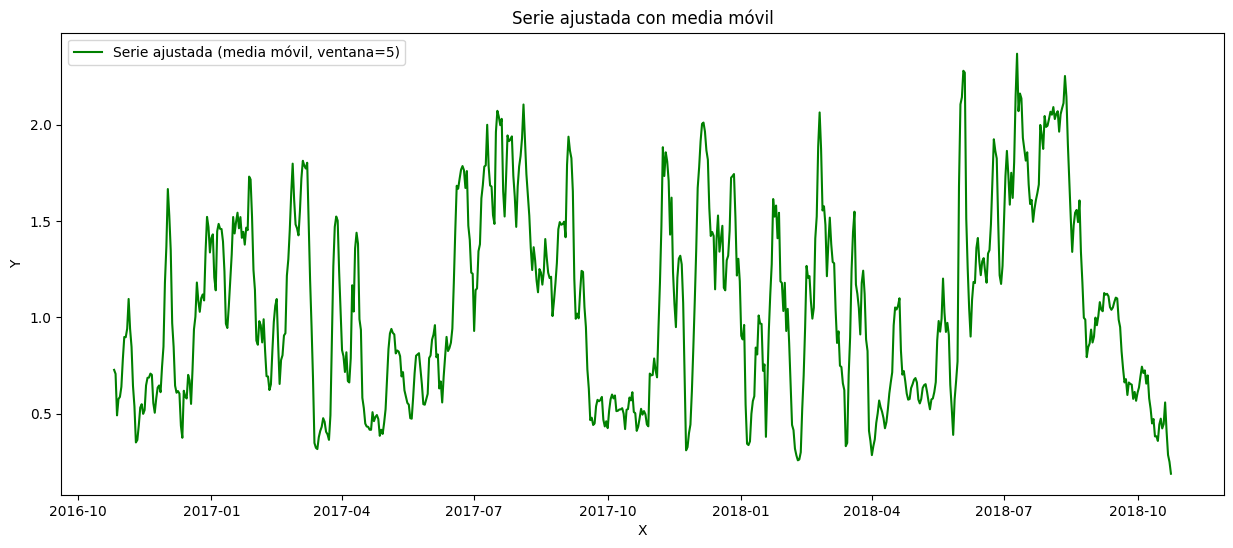

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                  -2.553507
p-value                          0.102992
#Lags Used                      20.000000
Number of Observations Used    708.000000
Critical Value (1%)             -3.439620
Critical Value (5%)             -2.865631
Critical Value (10%)            -2.568948
dtype: float64

Resultados de la Prueba de KPSS:
Test Statistic            0.147358
p-value                   0.100000
Lags Used                16.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/var/folders/67/ps7tp1qx2hzc8nh71972vsbm0000gp/T/ipykernel_41941/1410448124.py:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression='c')


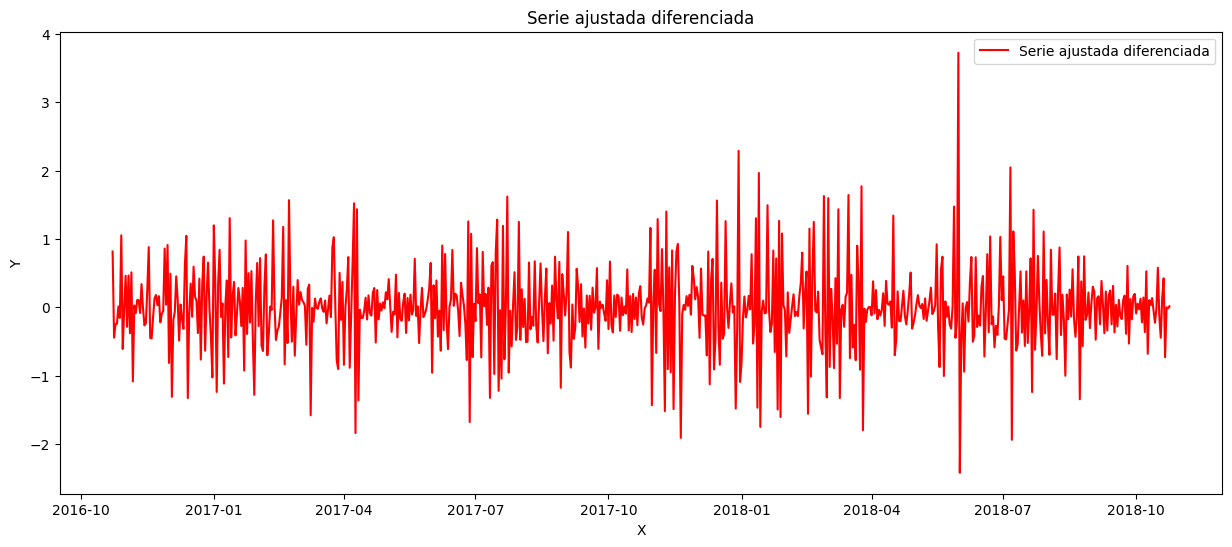

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.541982e+01
p-value                        3.045093e-28
#Lags Used                     6.000000e+00
Number of Observations Used    7.250000e+02
Critical Value (1%)           -3.439402e+00
Critical Value (5%)           -2.865535e+00
Critical Value (10%)          -2.568897e+00
dtype: float64

Resultados de la Prueba de KPSS:
Test Statistic            0.111547
p-value                   0.100000
Lags Used                85.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/var/folders/67/ps7tp1qx2hzc8nh71972vsbm0000gp/T/ipykernel_41941/1410448124.py:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression='c')


In [14]:
import pandas as pd
import matplotlib.pyplot as plt

df_ajustado = pd.DataFrame({'Serie_Ajustada': serie_ajustada_multiplicativa}, index=series.index)

window_size = 5
df_ajustado_rolling = df_ajustado.rolling(window=window_size).mean()

df_ajustado_diff = df_ajustado.diff()

plt.figure(figsize=(15, 6))
plt.plot(df_ajustado_rolling.index, df_ajustado_rolling['Serie_Ajustada'], color='green', label=f'Serie ajustada (media móvil, ventana={window_size})')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Serie ajustada con media móvil')
plt.show()

test_stationarity(df_ajustado_rolling['Serie_Ajustada'])

plt.figure(figsize=(15, 6))
plt.plot(df_ajustado_diff.index, df_ajustado_diff['Serie_Ajustada'], color='red', label='Serie ajustada diferenciada')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Serie ajustada diferenciada')
plt.show()

test_stationarity(df_ajustado_diff['Serie_Ajustada'])

**Resultados para media movil con ventana 5**:

Prueba de Dickey-Fuller:

Estadístico de Prueba (-2.553507): Es menos negativo que los valores críticos (-3.44, -2.87, -2.57), lo que sugiere que no hay suficiente evidencia para rechazar la hipótesis nula de no estacionariedad.
Valor p (0.102992): Es mayor que el nivel de significancia comúnmente utilizado de 0.05, lo que también sugiere que no hay suficiente evidencia para rechazar la hipótesis nula.

**Prueba de KPSS**:

Estadístico de Prueba (0.147358): Es mayor que los valores críticos (0.347, 0.463), lo que sugiere que hay suficiente evidencia para rechazar la hipótesis nula de estacionariedad.
Valor p (0.1): Es mayor que el nivel de significancia, lo que indica que no hay suficiente evidencia para rechazar la hipótesis nula.

En funcion a estos resultados se puede concluir que la serie no es estacionaria.

Resultados para serie diferenciada:

**Prueba de Dickey-Fuller**:

Estadístico de Prueba (-15.41982): Es mucho más negativo que los valores críticos (-3.44, -2.87, -2.57), lo que sugiere que hay suficiente evidencia para rechazar la hipótesis nula de no estacionariedad.
Valor p (3.045093e-28): Es extremadamente pequeño, prácticamente cero, lo que proporciona una fuerte evidencia en contra de la hipótesis nula de no estacionariedad.

**Prueba de KPSS**:

Estadístico de Prueba (0.111547): Es mayor que los valores críticos (0.347, 0.463), lo que sugiere que no hay suficiente evidencia para rechazar la hipótesis nula de estacionariedad.
Valor p (0.1): Es mayor que el nivel de significancia, lo que indica que no hay suficiente evidencia para rechazar la hipótesis nula.

En funcion a los resultados se puede concluir que la serie es estacionaria.

Dados estos resultados se trabajara con la serie original diferenciada una vez, dado que se obtuvo una serie estacionaria con una sola transformacion.

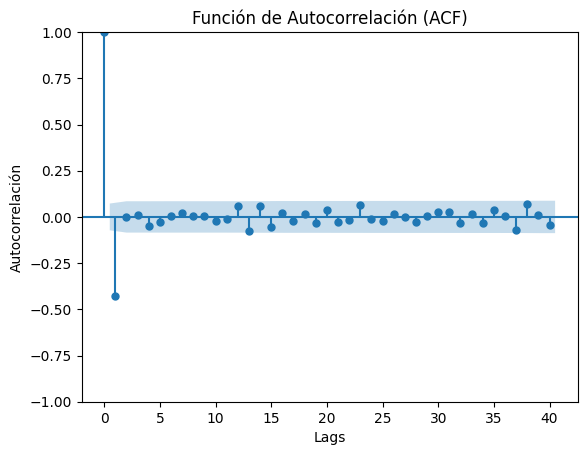

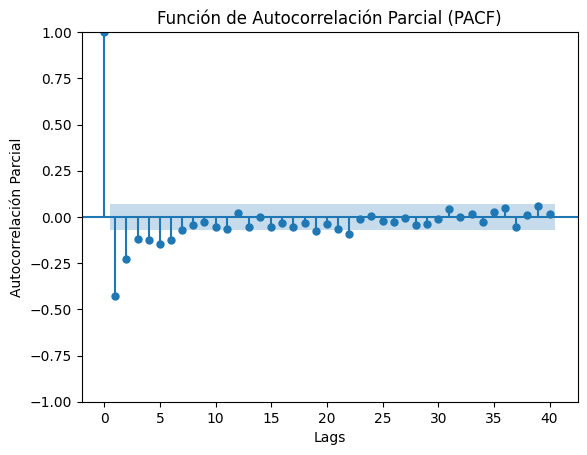

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Trazar ACF
plot_acf(df_ajustado_diff['Serie_Ajustada'].dropna(), lags=40)
plt.xlabel('Lags')
plt.ylabel('Autocorrelación')
plt.title('Función de Autocorrelación (ACF)')
plt.show()

# Trazar PACF
plot_pacf(df_ajustado_diff['Serie_Ajustada'].dropna(), lags=40)
plt.xlabel('Lags')
plt.ylabel('Autocorrelación Parcial')
plt.title('Función de Autocorrelación Parcial (PACF)')
plt.show()

Tanto para la autocorrelacion como para la autocorrelacion parcial los valores se vuelven rapidamente insignificantes conforme aumentan los lags. Esto indica una baja correlacion temporal.

En ambos casos el lag 1 parece ser el mas significativo. Esto ademas es ventajoso a la hora de armar el modelo SARIMA, dado que implica una menor cantidad de parametros.

En funcion a todos los resultados, un buen modelo SARIMA para esta serie temporal seria de orden (1,1,1)

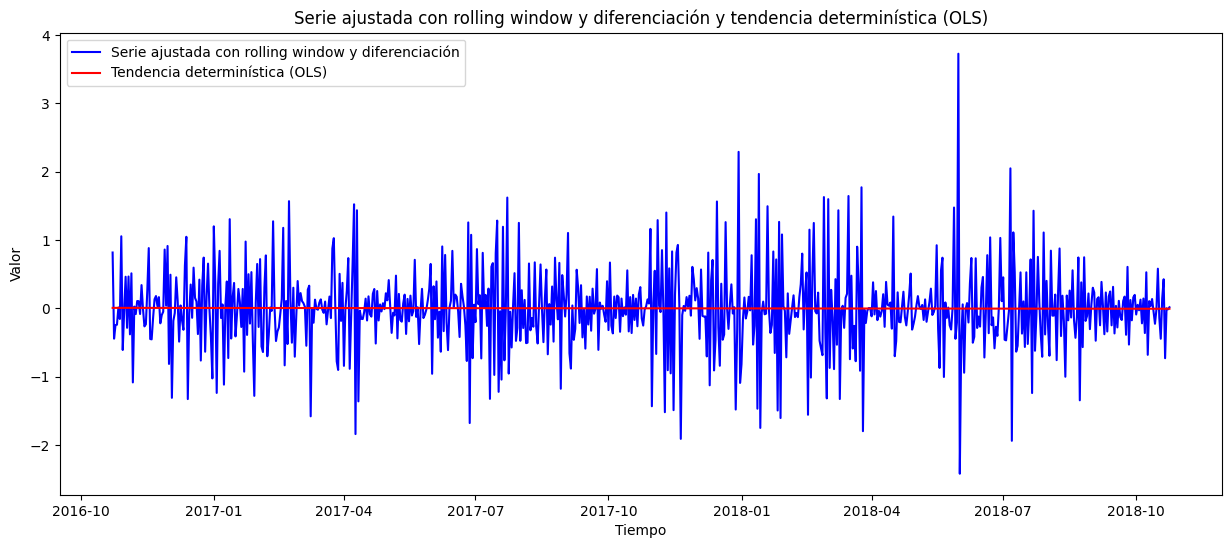

In [30]:
import statsmodels.api as sm

y = df_ajustado_diff['Serie_Ajustada'].dropna()

y_dates = y.index

x_with_const = sm.add_constant(np.arange(len(y)))

model_ols = sm.OLS(y, x_with_const).fit()

trend_ols = model_ols.predict(x_with_const)

plt.figure(figsize=(15, 6))
plt.plot(y_dates, y, color='blue', label='Serie ajustada con rolling window y diferenciación')
plt.plot(y_dates, trend_ols, color='red', label='Tendencia determinística (OLS)')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.title('Serie ajustada con rolling window y diferenciación y tendencia determinística (OLS)')
plt.show()

Considerando el grafico de autocorrelacion y la tendencia deterministica se podria considerar que la serie ajustada podria ser estacionaria, aunque no es suficiente para garantizarlo.

A partir de estos resultados se podria plantear un modelo SARIMA considerando lo siguiente: una diferenciacion de primer orden para el componente I, una ventana de 5 dias para el componente MA y utilizar un lag de 5 para el componente AR, dado que es el pico dentro del intervalo de confianza.  

/Users/rodrigo.pazos/projects/sts/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/rodrigo.pazos/projects/sts/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/rodrigo.pazos/projects/sts/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                         SARIMAX Results                                         
Dep. Variable:     Consumo Máximo Diario de Electricidad   No. Observations:                  733
Model:                                    ARIMA(1, 1, 0)   Log Likelihood                -377.180
Date:                                   Mon, 15 Apr 2024   AIC                            758.359
Time:                                           21:02:06   BIC                            767.551
Sample:                                       10-22-2016   HQIC                           761.905
                                            - 10-24-2018                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4204      0.022    -18.750      0.000    

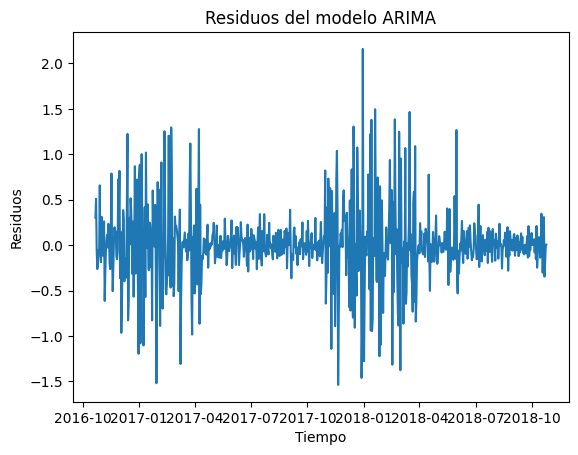

<Figure size 1000x400 with 0 Axes>

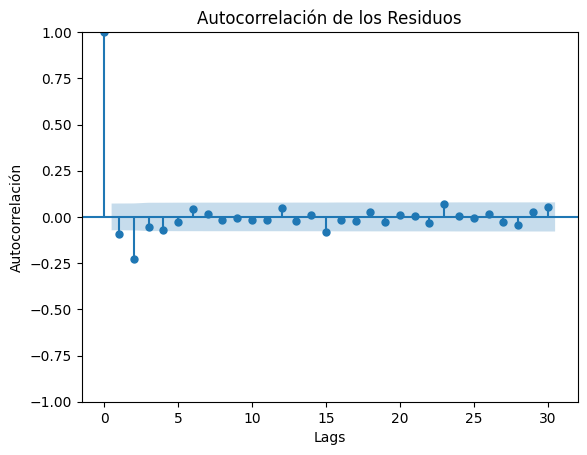

In [47]:
from statsmodels.tsa.arima.model import ARIMA

modelo_arima = ARIMA(series, order=(1, 1, 0))
modelo_arima_resultados = modelo_arima.fit()

print(modelo_arima_resultados.summary())

residuos = modelo_arima_resultados.resid
plt.plot(residuos)
plt.title('Residuos del modelo ARIMA')
plt.xlabel('Tiempo')
plt.ylabel('Residuos')
plt.show()

plt.figure(figsize=(10, 4))
plot_acf(residuos, lags=30, alpha=0.05)
plt.title('Autocorrelación de los Residuos')
plt.xlabel('Lags')
plt.ylabel('Autocorrelación')
plt.show()

/Users/rodrigo.pazos/projects/sts/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/rodrigo.pazos/projects/sts/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/rodrigo.pazos/projects/sts/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                         SARIMAX Results                                         
Dep. Variable:     Consumo Máximo Diario de Electricidad   No. Observations:                  733
Model:                                    ARIMA(1, 0, 1)   Log Likelihood                -327.636
Date:                                   Mon, 15 Apr 2024   AIC                            663.271
Time:                                           21:02:01   BIC                            681.660
Sample:                                       10-22-2016   HQIC                           670.365
                                            - 10-24-2018                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6068      0.133      4.550      0.000    

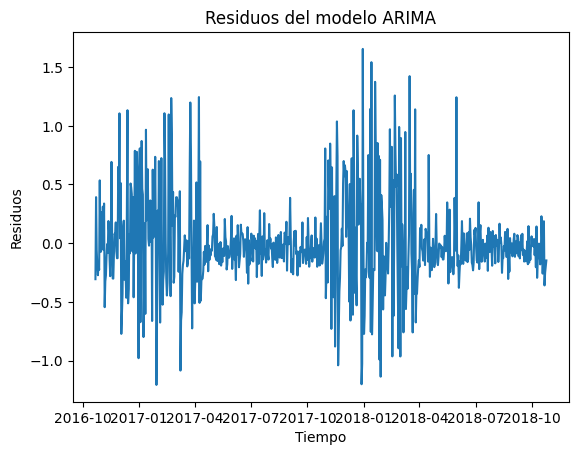

<Figure size 1000x400 with 0 Axes>

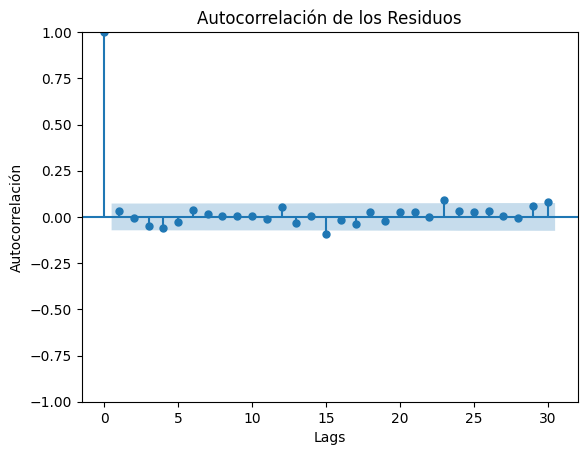

In [46]:
from statsmodels.tsa.arima.model import ARIMA

modelo_arima = ARIMA(series, order=(1, 0, 1))
modelo_arima_resultados = modelo_arima.fit()

print(modelo_arima_resultados.summary())

residuos = modelo_arima_resultados.resid
plt.plot(residuos)
plt.title('Residuos del modelo ARIMA')
plt.xlabel('Tiempo')
plt.ylabel('Residuos')
plt.show()

plt.figure(figsize=(10, 4))
plot_acf(residuos, lags=30, alpha=0.05)
plt.title('Autocorrelación de los Residuos')
plt.xlabel('Lags')
plt.ylabel('Autocorrelación')
plt.show()

/Users/rodrigo.pazos/projects/sts/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/rodrigo.pazos/projects/sts/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/rodrigo.pazos/projects/sts/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                         SARIMAX Results                                         
Dep. Variable:     Consumo Máximo Diario de Electricidad   No. Observations:                  733
Model:                                    ARIMA(0, 1, 1)   Log Likelihood                -338.047
Date:                                   Mon, 15 Apr 2024   AIC                            680.095
Time:                                           20:59:55   BIC                            689.286
Sample:                                       10-22-2016   HQIC                           683.641
                                            - 10-24-2018                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6632      0.020    -32.940      0.000    

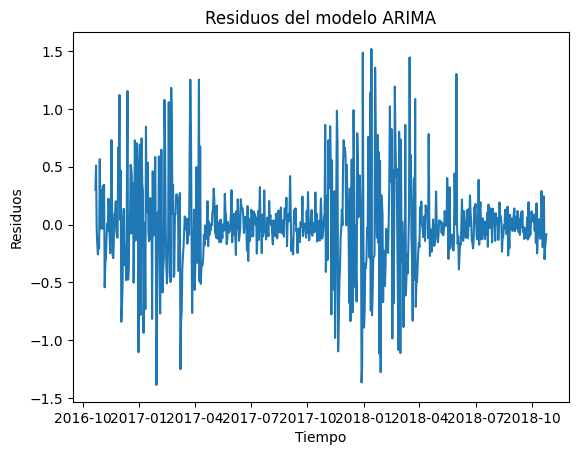

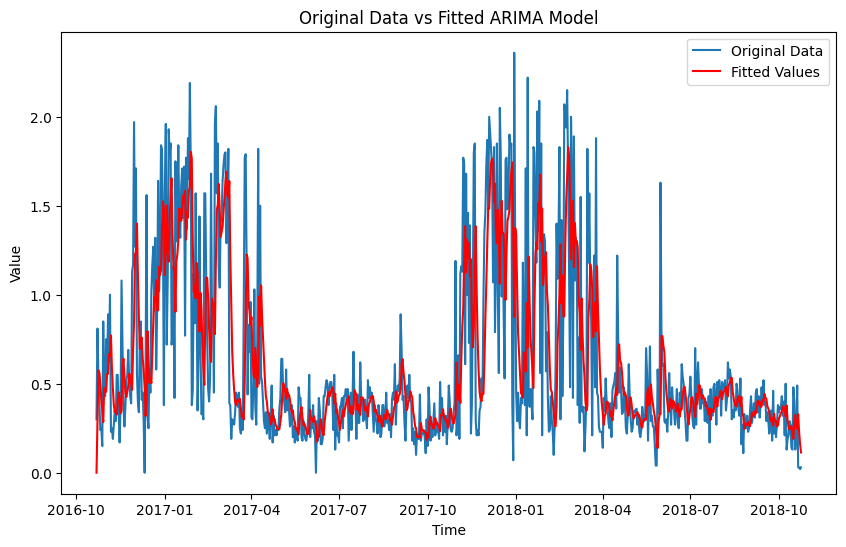

<Figure size 1000x400 with 0 Axes>

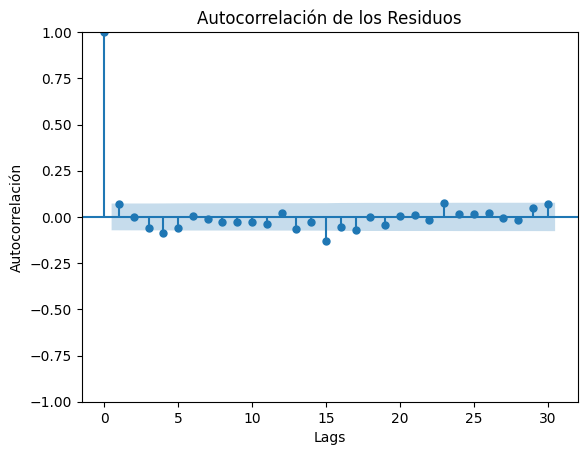

In [45]:
from statsmodels.tsa.arima.model import ARIMA

modelo_arima = ARIMA(series, order=(0, 1, 1))
modelo_arima_resultados = modelo_arima.fit()

print(modelo_arima_resultados.summary())

residuos = modelo_arima_resultados.resid
plt.plot(residuos)
plt.title('Residuos del modelo ARIMA')
plt.xlabel('Tiempo')
plt.ylabel('Residuos')
plt.show()

plt.figure(figsize=(10, 4))
plot_acf(residuos, lags=30, alpha=0.05)
plt.title('Autocorrelación de los Residuos')
plt.xlabel('Lags')
plt.ylabel('Autocorrelación')
plt.show()

/Users/rodrigo.pazos/projects/sts/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/rodrigo.pazos/projects/sts/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/rodrigo.pazos/projects/sts/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                         SARIMAX Results                                         
Dep. Variable:     Consumo Máximo Diario de Electricidad   No. Observations:                  733
Model:                                    ARIMA(1, 1, 1)   Log Likelihood                -332.298
Date:                                   Mon, 15 Apr 2024   AIC                            670.597
Time:                                           21:18:42   BIC                            684.384
Sample:                                       10-22-2016   HQIC                           675.915
                                            - 10-24-2018                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2473      0.032      7.793      0.000    

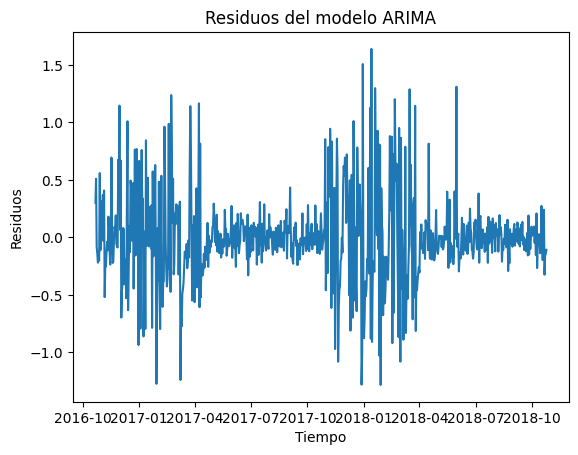

<Figure size 1000x400 with 0 Axes>

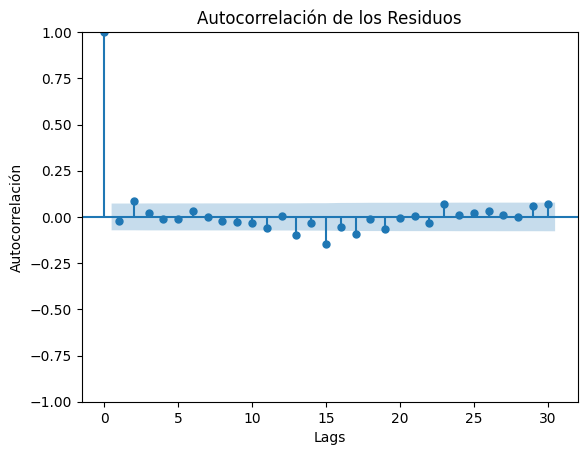

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Supongamos que 'series' es tu serie temporal
# Ajustar el modelo ARIMA
modelo_arima = ARIMA(series, order=(1, 1, 1))
modelo_arima_resultados = modelo_arima.fit()

# Mostrar el resumen del modelo
print(modelo_arima_resultados.summary())

residuos = modelo_arima_resultados.resid
plt.plot(residuos)
plt.title('Residuos del modelo ARIMA')
plt.xlabel('Tiempo')
plt.ylabel('Residuos')
plt.show()

plt.figure(figsize=(10, 4))
plot_acf(residuos, lags=30, alpha=0.05)
plt.title('Autocorrelación de los Residuos')
plt.xlabel('Lags')
plt.ylabel('Autocorrelación')
plt.show()

- Valor p (Prob(Q)): Si el valor p es menor que un nivel de significancia predefinido (generalmente 0.05), se rechaza la hipótesis nula de no autocorrelación en los residuos. Esto indica que hay autocorrelación significativa en los residuos en el lag 1.
- Valor p (Prob(JB)): Si el valor p es menor que un nivel de significancia predefinido (generalmente 0.05), se rechaza la hipótesis nula de que los residuos tienen una distribución normal.

El mejor modelo pareciera ser el SARIMA de orden (1,0,1). Este presenta el LL mas grande (-327.636), el AIC y el BIC mas pequeños (663.271 y 681.660, respectivamente). Ademas presenta un Valor p mayor a 0.05, por lo que no se puede rechazar la hipotesis nula de no autocorrelacion. En terminos de normalidad de los errores, se debe rechazar la hipotesis nula de una distribucion normal. 

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras import regularizers

# Escalado de datos
scaler = MinMaxScaler(feature_range=(0, 1))
series_scaled = scaler.fit_transform(series.values.reshape(-1, 1))

# Preparación de los datos para la LSTM
def create_dataset(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 20  # Número de pasos temporales para predecir el siguiente valor
X, y = create_dataset(series_scaled, time_steps)

# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(len(X) * 0.6)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reestructurar los datos para LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Definir el modelo LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
# model.add(Dropout(0.2))  # Dropout con una tasa del 20%
model.add(LSTM(units=50))
# model.add(Dropout(0.2))  # Dropout adicional
model.add(Dense(units=1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)


Epoch 1/100


/Users/rodrigo.pazos/projects/sts/venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0832
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0344
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0358
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0372
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0311
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0330
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0296
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0379
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0338
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0310
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0335
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0289
Epoch 13/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0324
Epoch 14/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0324
Epoch 15/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0354
Epoch 16/100


Train Loss: 0.025946367532014847
Test Loss: 0.025249889120459557
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


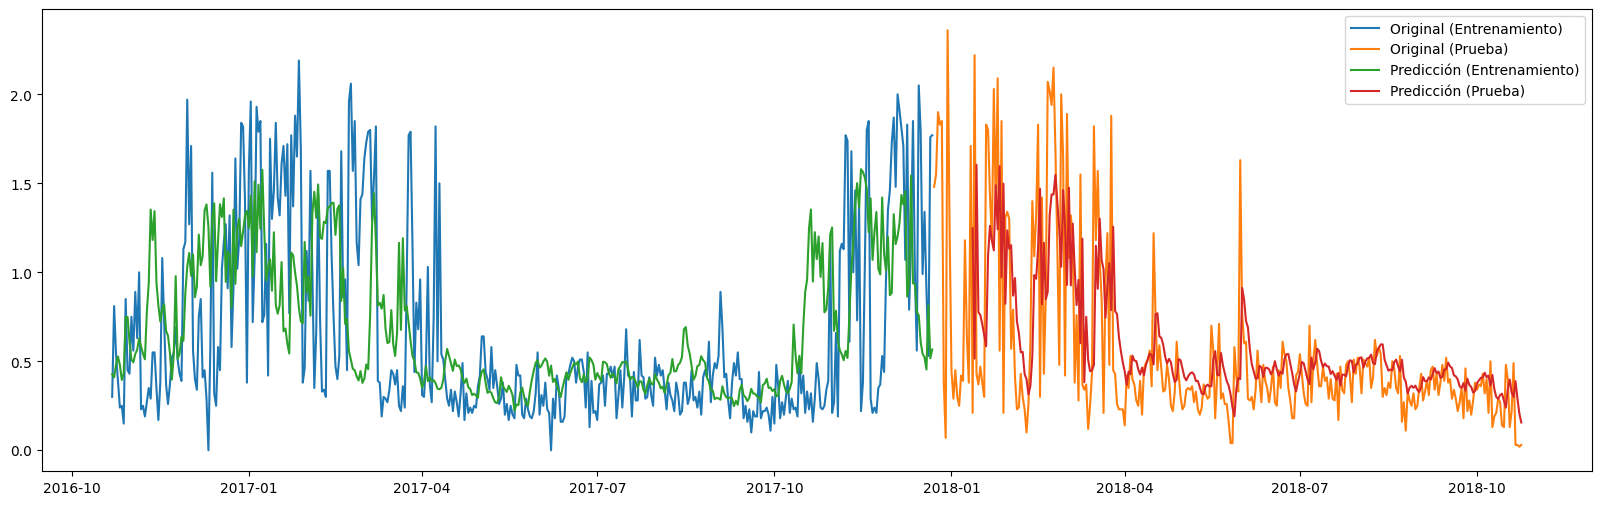

In [74]:
# Evaluar el modelo
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print("Train Loss:", train_loss)
print("Test Loss:", test_loss)

# Realizar predicciones
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invertir el escalado para obtener los valores reales
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Graficar resultados
plt.figure(figsize=(20, 6))
plt.plot(series.index[:len(train_predict)], series[:len(train_predict)], label='Original (Entrenamiento)')
plt.plot(series.index[len(train_predict):], series[len(train_predict):], label='Original (Prueba)')
plt.plot(series.index[:len(train_predict)], train_predict, label='Predicción (Entrenamiento)')
plt.plot(series.index[len(train_predict) + time_steps:], test_predict, label='Predicción (Prueba)')
plt.legend()
plt.show()

In [76]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Divide los datos en conjuntos de entrenamiento y prueba
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

# Función para entrenar y evaluar un modelo SARIMA
def train_evaluate_sarima(train, test, order):
    # Entrena el modelo SARIMA
    model = ARIMA(train, order=order)
    model_fit = model.fit()

    # Realiza predicciones en el conjunto de prueba
    predictions = model_fit.forecast(steps=len(test))

    # Calcula el error cuadrático medio
    mse = mean_squared_error(test, predictions)
    return mse

# Función para entrenar y evaluar un modelo LSTM
def train_evaluate_lstm(train, test, n_steps):
    # Escala los datos entre 0 y 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
    test_scaled = scaler.transform(test.values.reshape(-1, 1))

    # Prepara los datos para el modelo LSTM
    def prepare_data(data, n_steps):
        X, y = [], []
        for i in range(len(data)):
            end_ix = i + n_steps
            if end_ix > len(data)-1:
                break
            seq_x, seq_y = data[i:end_ix], data[end_ix]
            X.append(seq_x)
            y.append(seq_y)
        return np.array(X), np.array(y)

    X_train, y_train = prepare_data(train_scaled, n_steps)
    X_test, y_test = prepare_data(test_scaled, n_steps)

    # Define el modelo LSTM
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Entrena el modelo LSTM
    model.fit(X_train, y_train, epochs=200, verbose=0)

    # Realiza predicciones en el conjunto de prueba
    predictions = model.predict(X_test, verbose=0)

    # Invierte la escala de las predicciones
    predictions = scaler.inverse_transform(predictions)

    # Calcula el error cuadrático medio
    mse = mean_squared_error(test[n_steps:], predictions)
    return mse

# Especifica los órdenes para el modelo SARIMA y el número de pasos para el modelo LSTM
sarima_order = (1, 0, 1)  # Ejemplo de orden SARIMA
n_steps = 3  # Ejemplo de número de pasos para LSTM

# Entrena y evalúa los modelos SARIMA y LSTM
mse_sarima = train_evaluate_sarima(train, test, sarima_order)
mse_lstm = train_evaluate_lstm(train, test, n_steps)

# Compara los resultados
print("Error cuadrático medio (MSE) SARIMA:", mse_sarima)
print("Error cuadrático medio (MSE) LSTM:", mse_lstm)


/Users/rodrigo.pazos/projects/sts/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/rodrigo.pazos/projects/sts/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/rodrigo.pazos/projects/sts/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/rodrigo.pazos/projects/sts/venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Error cuadrático medio (MSE) SARIMA: 0.1161823584331719
Error cuadrático medio (MSE) LSTM: 0.022683513057761156


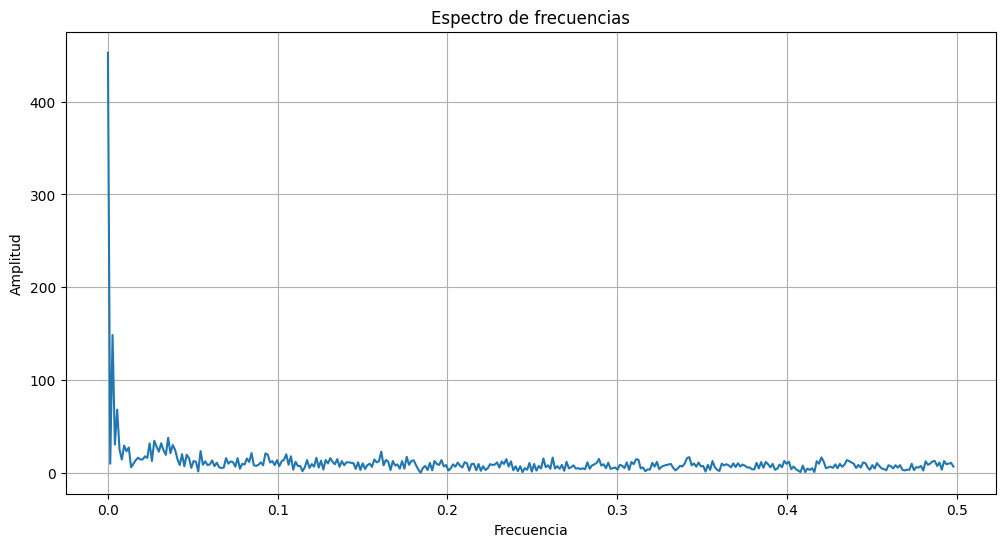

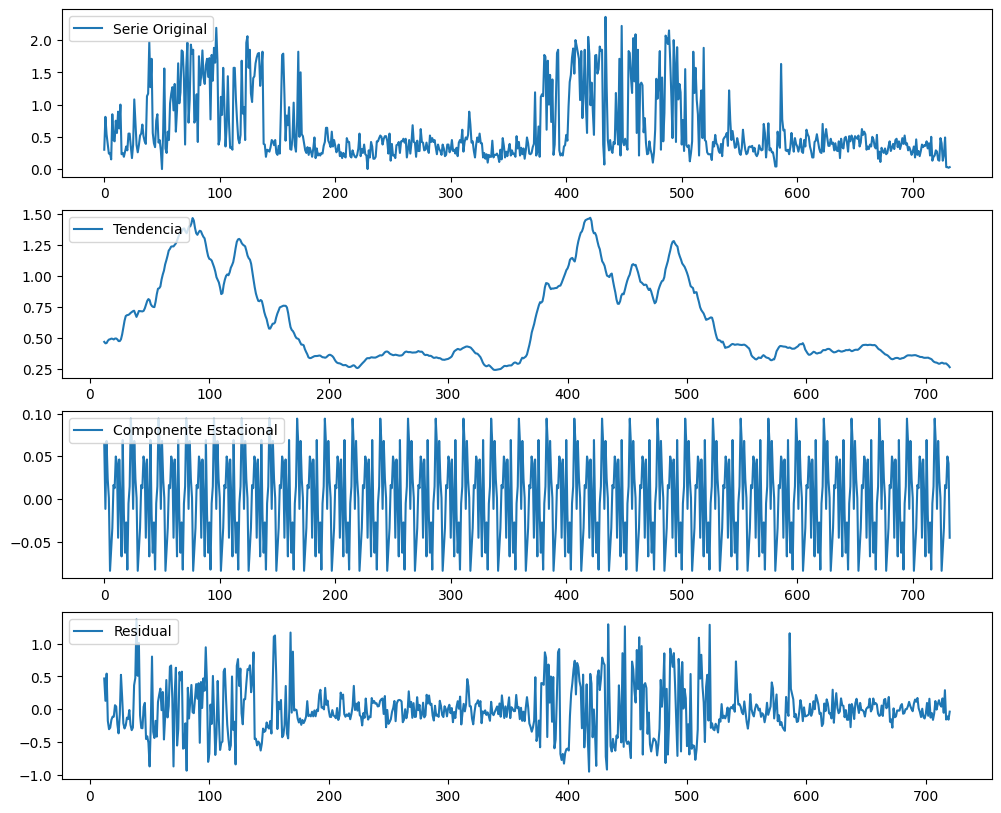

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from statsmodels.tsa.seasonal import seasonal_decompose

# Calcula la transformada de Fourier de la serie
series = series.dropna()
# Reemplazar infinitos con NaN y luego eliminar filas con valores faltantes
series = series.replace([np.inf, -np.inf], np.nan).dropna()

series = np.array(series)

fft_result = fft(series)

# Calcula las frecuencias correspondientes
n = len(series)
frequencies = np.fft.fftfreq(n)

# Encuentra las amplitudes y las frecuencias principales
amplitudes = np.abs(fft_result)[:n//2]
frequencies = frequencies[:n//2]

# Plotea el espectro de frecuencias
plt.figure(figsize=(12, 6))
plt.plot(frequencies, amplitudes)
plt.title('Espectro de frecuencias')
plt.xlabel('Frecuencia')
plt.ylabel('Amplitud')
plt.grid(True)
plt.show()

# Realiza una descomposición estacional de la serie
decomposition = seasonal_decompose(series, model='additive', period=24)  # Aquí asumimos un período estacional de 24
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plotea las componentes de la descomposición
plt.figure(figsize=(12, 10))
plt.subplot(411)
plt.plot(series, label='Serie Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Componente Estacional')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='upper left')
plt.show()
